---
title: "1D Forward Simulation of Frequency Domain EM Data for a Single Sounding"
authors:
  - id: devincowan
---

```{admonition} Introductory notebook
:class: hint
This tutorial teaches basic functionality within SimPEG and is a good entry point for new users.
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

**Keywords:** FDEM, forward simulation, 1D sounding, inductive source, wires mapping.

</br>

**Summary:** In this tutorial, we present the fundamentals of simulating FDEM data in SimPEG. We use the module [simpeg.electromagnetics.static.frequency_domain](xref:simpeg#simpeg.electromagnetics.frequency_domain) to simulate FDEM data for a 1D sounding. The [Simulation1DLayered](xref:simpeg#simpeg.electromagnetics.frequency_domain.simulation_1d.Simulation1DLayered) class is used to solve the problem via a semi-analytic Hankel transform solution. Note that almost all of what is learned here can be applied to simulating 3D FDEM data.

**Learning Objectives:**

- The fundamentals of simulating FDEM data with SimPEG.
- Understanding the way in which FDEM surveys are created in SimPEG, which includes:
    - Defining receivers
    - Defining controlled sources
    - Organizing sources and receivers into a survey object
- Defining the Earth's electrical properties in terms of conductivity OR resistivity.
- The ways in which we can define 1D layered Earth models.
- Defining appropriate mappings from the model parameters to parameters defining the simulation.

## Importing Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to FDEM is imported from [simpeg.electromagnetics.frequency_domain](xref:simpeg#simpeg.electromagnetics.frequency_domain).
We also import some useful utility functions from [simpeg.utils](xref:simpeg#simpeg.utils).

In [1]:
# SimPEG functionality
import simpeg.electromagnetics.frequency_domain as fdem
from simpeg import maps
from simpeg.utils import plot_1d_layer_model

# Common Python functionality
import os
import numpy as np
from scipy.constants import mu_0
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({"font.size": 14})

write_output = False  # Optional

## Defining the Survey

FDEM surveys within SimPEG require the user to create and connect three types of objects:

- **receivers:** There are a multitude of FDEM receiver classes within SimPEG, each of which is used to simulate data corresponding to a different field measurement; e.g. [PointMagneticField](xref:simpeg#simpeg.electromagnetics.frequency_domain.receivers.PointMagneticField) and [PointElectricField](xref:simpeg#simpeg.electromagnetics.frequency_domain.receivers.PointElectricField). The properties for each FDEM receiver object generally include: the orientation of the field being measured (x, y, z, other), the component (real or imaginary), the data type (field or ppm), and one or more associated observation locations.
- **sources:** There are a multitude of FDEM source classes within SimPEG, each of which corresponds to a different geometry; e.g. [MagDipole](xref:simpeg#simpeg.electromagnetics.frequency_domain.sources.MagDipole), [CircularLoop](xref:simpeg#simpeg.electromagnetics.frequency_domain.sources.CircularLoop) and [LineCurrent](xref:simpeg#simpeg.electromagnetics.frequency_domain.sources.LineCurrent). Source classes generally require the user to define the operating frequency (in Hz), its location and its geometry.
- **survey:** the object which stores and organizes all of the sources and receivers.

For a full description of all source and receiver classes, please visit API documentation for [simpeg.electromagnetics.frequency_domain](xref:simpeg#simpeg.electromagnetics.frequency_domain).

**Topography:** When generating the survey for a 1D forward simulation, sources and receivers **must** be located **above** the Earth's surface. By default, the Earth's surface is at z = 0 m when defining the 1D simulation. So for 1D FDEM problems, it is easiest to define the z-locations of all sources and receivers as flight heights.

**For this tutorial**, the survey consists of a vertical magnetic dipole source operating at 5 frequencies. Real and imaginary data in ppm are measured by a vertically-oriented receiver coil offset 10 m from the source.

In [2]:
# Source properties
frequencies = np.r_[382, 1822, 7970, 35920, 130100]  # frequencies in Hz
source_location = np.array([0.0, 0.0, 30.0])  # (3, ) numpy.array_like
source_orientation = "z"  # "x", "y" or "z"
moment = 1.0  # dipole moment in Am^2

# Receiver properties
receiver_locations = np.array([10.0, 0.0, 30.0])  # or (N, 3) numpy.ndarray
receiver_orientation = "z"  # "x", "y" or "z"
data_type = "ppm"  # "secondary", "total" or "ppm"

The most general way to generate FDEM surveys is to loop over all sources. A new source object must be created whenever the source location, geometry and/or operating frequencies differs. For each source, we define and assign the associated receivers. A different receiver object must be created whenever geometry or data type differs. However, identical data being collected at a multitude of observation locations can be defined using a single receiver object.   

**For this tutorial**, the location and geometry of the source remains the same, so we only need to loop over the operating frequencies. And since we have both real and imaginary data, we will need to define two receivers for each source. More complicated survey geometries are used in the [3D Forward Simulation of FDEM Data on Cylindrical Mesh for a Galvanic Source](fwd_fdem_cyl.ipynb) and [Forward Simulation of 3D Airborne FDEM Data on a Tree Mesh](fwd_fdem_3d.ipynb) tutorials.

In [3]:
source_list = []  # create empty list for source objects

# loop over all sources
for freq in frequencies:
    # Define receivers that measure real and imaginary component
    # magnetic field data in ppm.
    receiver_list = []
    receiver_list.append(
        fdem.receivers.PointMagneticFieldSecondary(
            receiver_locations,
            orientation=receiver_orientation,
            data_type=data_type,
            component="real",
        )
    )
    receiver_list.append(
        fdem.receivers.PointMagneticFieldSecondary(
            receiver_locations,
            orientation=receiver_orientation,
            data_type=data_type,
            component="imag",
        )
    )

    # Define a magnetic dipole source at each frequency
    source_list.append(
        fdem.sources.MagDipole(
            receiver_list=receiver_list,
            frequency=freq,
            location=source_location,
            orientation=source_orientation,
            moment=moment,
        )
    )

# Define the FDEM survey
survey = fdem.survey.Survey(source_list)

## Defining a 1D Layered Earth and the Model

In SimPEG, a 1D layered Earth is defined by the set of layer thicknesses and the physical properties for each layer. Thicknesses and physical property values are defined from the top layer down. If we have N layers, we define N physical property values and N-1 layer thicknesses. The lowest layer is assumed to extend to infinity. In the case of a halfspace, the layer thicknesses would be an empty array.

In [4]:
# Define layer thicknesses (m)
layer_thicknesses = np.array([20.0, 40.0])

# Define layer conductivities (S/m)
layer_conductivities = np.r_[0.1, 1.0, 0.1]

# Define layer susceptibilities (SI)
layer_susceptibilities = np.r_[0.0, 4.0, 0.0]

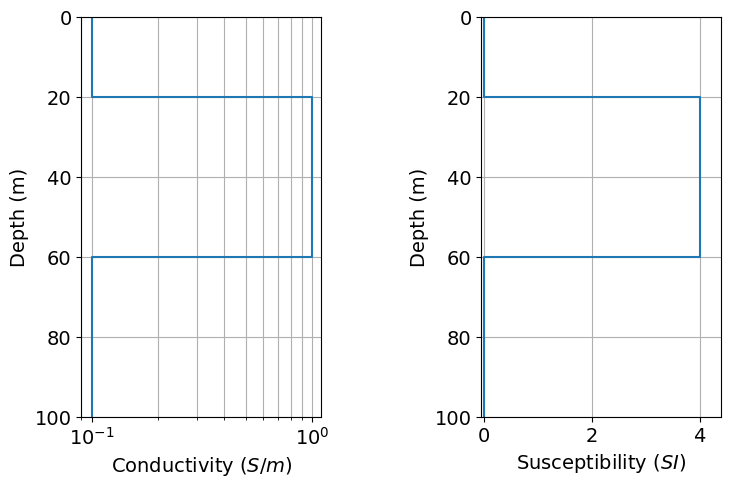

In [5]:
fig = plt.figure(figsize=(8, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.3, 0.8])
ax1 = plot_1d_layer_model(layer_thicknesses, layer_conductivities, scale="log", ax=ax1)
ax1.grid(which="both")
ax1.set_xlabel(r"Conductivity ($S/m$)")

ax2 = fig.add_axes([0.6, 0.1, 0.3, 0.8])
ax2 = plot_1d_layer_model(
    layer_thicknesses, layer_susceptibilities, scale="linear", ax=ax2
)
ax2.grid(which="both")
ax2.set_xlim([-0.05, 1.1 * np.max(layer_susceptibilities)])
ax2.set_xlabel(r"Susceptibility ($SI$)")
plt.show()

## Models and Mappings for 1D Simulations

In SimPEG, the term 'model' is not necessarily synonymous with a set of physical property values. For example, the model may be defined as the logarithms of the physical property values, or be the parameters defining a layered Earth geometry. Models in SimPEG are 1D [numpy.ndarray](xref:numpy#numpy.ndarray) whose lengths are equal to the number of model parameters. For 1D FDEM simulations, we can characterize the Earth's electric properties according to electrical conductivity or electrical resistivity.

Classes within the ``simpeg.maps`` module are used to define the mapping that connects the model to the parameters required to run the 1D FDEM simulation; i.e. layer conductivities/resistivities, magnetic permeabilities and/or layer thicknesses. In this tutorial, we demonstrate several types of mappings and models that may be used for 1D FDEM simulation.

**CASE 1: Conductivity model.** The easiest case is when the layer thicknesses are fixed in the simulation, and by default we assume the Earth is non-permeable. Here, we define the model as the layer conductivities. And the mapping from the model to the conductivities is defined using the [simpeg.maps.IdentityMap](xref:simpeg#simpeg.maps.IdentityMap) class.

**CASE 2: Log-resistivity model with fixed magnetic permeability.** Here, the model parameters are the log-resistivity values for the layers. In addition to fixing the layer thicknesses in the simulation, we need to fix the magnetic permeabilities. In this case, we need a mapping that converts log-resistivities to resistivities. To do this, we use the [simpeg.maps.ExpMap](xref:simpeg#simpeg.maps.ExpMap) class.

**CASE 3: Log-conductivity, magnetic permeability and layer thicknesses.** In this case, the model defines log-conductivities, magnetic permeabilities and layer thicknesses. We therefore need mappings that extract each parameter type from the model, and a converts to the appropriate quantity. For this, we require the [simpeg.maps.Wires](xref:simpeg#simpeg.maps.Wires) mapping and [simpeg.maps.ExpMap](xref:simpeg#simpeg.maps.ExpMap) mapping classes. Note that successive mappings can be chained together using the $*$ operator.

### Define the Models

In [6]:
n_layers = len(layer_conductivities)

# CASE 1: CONDUCTIVITY MODEL
conductivity_model = layer_conductivities.copy()

# CASE 2: LOG-RESISTIVITY MODEL
log_resistivity_model = np.log(1 / layer_conductivities)

# CASE 3: LOG-CONDUCTIVITY, MAGNETIC PERMEABILITY AND LAYER THICKNESSES
parametric_model = np.r_[
    np.log(layer_conductivities), mu_0 * (1 + layer_susceptibilities), layer_thicknesses
]

### Define the Mappings

In [7]:
# CASE 1: CONDUCTIVITY MODEL
conductivity_map = maps.IdentityMap()

# CASE 2: LOG-RESISTIVITY MODEL
log_resistivity_map = maps.ExpMap()

# CASE 3: LOG-CONDUCTIVITY, MAGNETIC PERMEABILITY AND LAYER THICKNEESSES
# Note the ordering in which you defined the model parameters and the
# order in which you defined the wire mappings matters!!!
wire_map = maps.Wires(
    ("log_conductivity", n_layers),
    ("permeability", n_layers),
    ("thicknesses", n_layers - 1),
)
log_conductivity_map = maps.ExpMap() * wire_map.log_conductivity
permeability_map = wire_map.permeability
thicknesses_map = wire_map.thicknesses

## Defining the Forward Simulation

In SimPEG, the physics of the forward simulation is defined by creating an instance of an appropriate simulation class. Here, we use the [Simulation1DLayered](xref:simpeg#simpeg.electromagnetics.frequency_domain.Simulation1DLayered) which simulates the data according to a 1D Hankel transform solution. To fully define the forward simulation, we need to connect the simulation object to:

- the survey
- the layer thicknesses
- the layer conductivities/resistivities
- the layer magnetic permeabilities (optional)

This is accomplished by setting each one of the aforementioned items as a property of the simulation object. Since the parameters defining the model in each case are different, we must define a separate simulation object for each case.

**CASE 1: Conductivity model.** Here, the model parameters are the layer conductivities. ``sigmaMap`` is used to define the mapping from the model to the layer conductivities. ``thicknessess`` is used to set the layer thicknesses as static parameters of the simulation. By default, the simulation assumes the Earth is non-permeable and we do not have to set this property.

In [8]:
simulation_conductivity = fdem.Simulation1DLayered(
    survey=survey,
    thicknesses=layer_thicknesses,
    sigmaMap=conductivity_map,
)

**CASE 2: Log-resistivity model with fixed magnetic permeability.** Here, the model parameters are the log-resistivities of the layers. Because we are now working with electric resistivity, ``rhoMap`` is used to define the mapping for the Earth's electrical properties; i.e. model parameters to layer resistivities. ``thicknessess`` is used to set the layer thicknesses as static parameters in the simulation. Likewise, ``mu`` is used to set the magnetic permeabilities.

In [9]:
simulation_log_resistivity = fdem.Simulation1DLayered(
    survey=survey,
    thicknesses=layer_thicknesses,
    rhoMap=log_resistivity_map,
)

**CASE 3: Log-conductivity, magnetic permeability and layer thicknesses.** Here, ``sigmaMap`` is used to define the mapping from the model to the layer conductivities. ``muMap`` is used to define the mapping from the model to the layer permeabilities. And ``thicknessesMap`` is used to define the mapping from the model to the layer thicknesses.

In [10]:
simulation_parametric = fdem.Simulation1DLayered(
    survey=survey,
    thicknessesMap=thicknesses_map,
    sigmaMap=log_conductivity_map,
    muMap=permeability_map,
)

## Predict 1D FDEM Data

Once any simulation within SimPEG has been properly constructed, simulated data for a given model vector can be computed using the [dpred](xref:simpeg#simpeg.simulation.BaseSimulation.dpred) method. Note that despite the difference in how we defined the model, the data predicted for CASE 1 and CASE 2 should be the same. And for CASE 3, we expect to see differences given the layer is now significantly permeable.

For surveys consisting of multiple sources, multiple receivers per source and multiple observation locations per receiver, the predicted data vector is organized:

- by source
- by receiver, then
- by observation location

In [11]:
dpred_conductivity = simulation_conductivity.dpred(conductivity_model)
dpred_log_resistivity = simulation_log_resistivity.dpred(log_resistivity_model)
dpred_parametric = simulation_parametric.dpred(parametric_model)

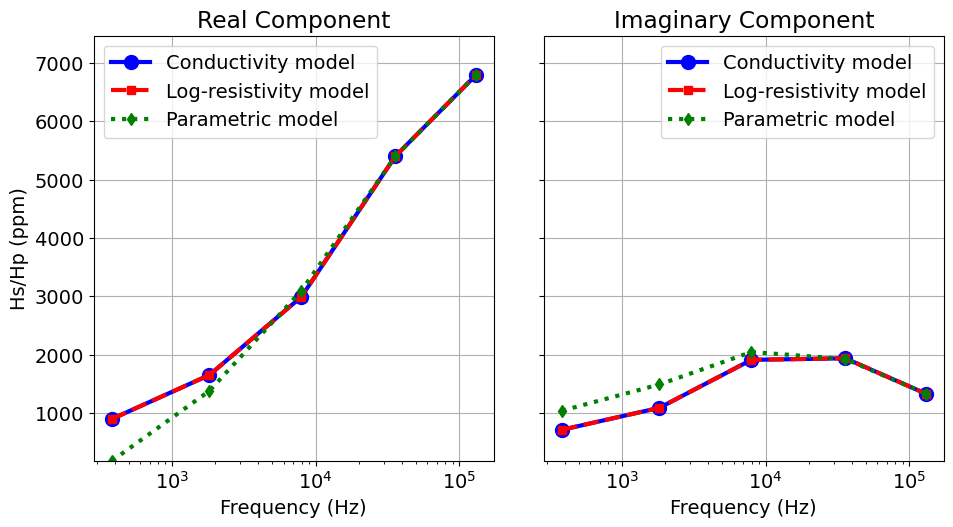

In [12]:
ylim = [np.min(dpred_parametric), 1.1 * np.max(dpred_parametric)]

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.4, 0.85])
ax1.semilogx(frequencies, dpred_conductivity[0::2], "b-o", lw=3, ms=10)
ax1.semilogx(frequencies, dpred_log_resistivity[0::2], "r--s", lw=3, ms=6)
ax1.semilogx(frequencies, dpred_parametric[0::2], "g:d", lw=3, ms=6)
ax1.grid()
ax1.set_ylim(ylim)
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Hs/Hp (ppm)")
ax1.set_title("Real Component")
ax1.legend(["Conductivity model", "Log-resistivity model", "Parametric model"])

ax2 = fig.add_axes([0.55, 0.1, 0.4, 0.85])
ax2.semilogx(frequencies, dpred_conductivity[1::2], "b-o", lw=3, ms=10)
ax2.semilogx(frequencies, dpred_log_resistivity[1::2], "r--s", lw=3, ms=6)
ax2.semilogx(frequencies, dpred_parametric[1::2], "g:d", lw=3, ms=6)
ax2.set_ylim(ylim)
ax2.grid()
ax2.set_xlabel("Frequency (Hz)")
ax2.set_yticklabels("")
ax2.set_title("Imaginary Component")
ax2.legend(["Conductivity model", "Log-resistivity model", "Parametric model"])

plt.show()

**Optional:** Export data.

In [13]:
if write_output:
    dir_path = os.path.sep.join([".", "fwd_fdem_1d_outputs"]) + os.path.sep
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    rng = np.random.default_rng(seed=222)
    noise = rng.normal(
        scale=0.05 * np.abs(dpred_conductivity),
        size=len(dpred_conductivity),
    )
    dpred_out = dpred_conductivity + noise

    fname = dir_path + "em1dfm_data.txt"
    np.savetxt(
        fname,
        np.c_[frequencies, dpred_out[0::2], dpred_out[1::2]],
        fmt="%.4e",
        header="FREQUENCY HZ_REAL HZ_IMAG",
    )